In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl.drawing.image import Image
from io import BytesIO
from math import sin, cos, exp, sqrt, pi
from typing import Callable, Tuple, List, Dict
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Experiment variables
POP_SIZE = 50
N1 = 5
N2 = 15
N3 = 30
DOMAIN_R = (-30, 30)
DOMAIN_S = (-100, 100)
DOMAIN_W = (-10.24, 10.24)
MAX_EVALUATIONS = 10000

In [4]:
# Evaluation functions
import numpy as np

def rosenbrock(x: np.ndarray) -> float:
    """
    The Generalized Rosenbrock function is a non-convex function used as a performance test problem for optimization algorithms.
    It is also known as the "banana function" due to the shape of its contours.

    Parameters:
    x (np.ndarray): Input array of shape (n,).

    Returns:
    float: The value of the Generalized Rosenbrock function at the given point.
    """
    n = len(x)
    result = 0.0
    for i in range(n - 1):
        result += 100 * (x[i + 1] - x[i] ** 2) ** 2 + (1 - x[i]) ** 2
    return result

def salomon(x: np.ndarray) -> float:
    """
    The Salomon function is commonly used as a benchmark for evaluating optimization algorithms.
    It has a single global minimum at the origin and many local minima, which makes it a challenging problem for optimization.

    Parameters:
    x (np.ndarray): Input array of shape (n,).

    Returns:
    float: The value of the Salomon function at the given point.
    """
    norm = np.linalg.norm(x)
    result = 1 - np.cos(2 * np.pi * norm) + 0.1 * norm
    return result

def whitley(x: np.ndarray) -> float:
    """
    The Whitley function is a highly multimodal function often used to test the robustness of optimization algorithms.
    It has numerous local minima, making it difficult to optimize.

    Parameters:
    x (np.ndarray): Input array of shape (n,).

    Returns:
    float: The value of the Whitley function at the given point.
    """
    n = len(x)
    result = 0.0
    for i in range(n):
        for j in range(n):
            term = 100 * (x[i] ** 2 - x[j]) ** 2 + (1 - x[j]) ** 2
            result += (term ** 2) / 4000.0 - np.cos(term) + 1
    return result

### Simplified Rosenbrock Function (Generalized)
The Rosenbrock function (generalized to higher dimensions) is defined as:

$$
f(x) = \sum_{j=0}^{D-2} \left[100(x_{j+1} - x_j^2)^2 + (x_j - 1)^2\right]
$$

### Salomon Function
The Salomon function is defined as:

$$
f(x) = - \cos\left(2\pi \sqrt{\sum_{j=0}^{D-1} x_j^2}\right) + 0.1 \sqrt{\sum_{j=0}^{D-1} x_j^2} + 1 
$$

### Whitley Function
The Whitley function is given by:

$$
f(x) = \sum_{j=0}^{D-1} \sum_{k=0}^{D-1} \left(\frac{(100(x_k - x_j^2)^2 + (1 - x_j)^2)^2}{4000} - \cos\left(100(x_k - x_j^2)^2 + (1 - x_j)^2\right) + 1\right)
$$

In [4]:
def binary_to_real(binary_population: np.ndarray, domain: Tuple[float, float], dimensions: int) -> np.ndarray:
    """
    Convert a binary population to a real-valued matrix.

    Args:
        binary_population (np.ndarray): Binary encoded population.
        domain (Tuple[float, float]): Lower and upper bounds for real values.
        dimensions (int): Number of dimensions.

    Returns:
        np.ndarray: Real-valued representation of the population.
    """
    max_value = 2 ** 16 - 1
    binary_values = binary_population.reshape(-1, dimensions, 16)
    int_values = binary_values.dot(2 ** np.arange(15, -1, -1))
    real_values = domain[0] + (int_values / max_value) * (domain[1] - domain[0])
    return real_values

In [5]:
# dynamic penalizing constraint handling
def calculate_penalty(x: np.ndarray, constraints: List[Callable[[np.ndarray], float]], weights: List[float]) -> float:
    """
    Calculate the penalty for constraint violations.

    Args:
        x (np.ndarray): Solution vector.
        constraints (List[Callable[[np.ndarray], float]]): List of constraint functions.
        weights (List[float]): List of penalty weights for the constraints.

    Returns:
        float: Penalty value.
    """
    penalty = 0.0
    for i, constraint in enumerate(constraints):
        value = constraint(x)
        if value > 0:  # Inequality constraint g(x) <= 0 is violated
            penalty += weights[i] * value
        elif value < 0:  # Equality constraint h(x) = 0
            penalty += weights[i] * abs(value)
    return penalty

def update_weights(weights: List[float], population: np.ndarray, constraints: List[Callable[[np.ndarray], float]],
                   increase_rate: float, decrease_rate: float):
    """
    Dynamically update the weights for each constraint based on violations in the population.

    Args:
        weights (List[float]): Current weights for the constraints.
        population (np.ndarray): The population of solutions.
        constraints (List[Callable[[np.ndarray], float]]): List of constraint functions.
        increase_rate (float): Rate to increase the weights.
        decrease_rate (float): Rate to decrease the weights.
    """
    # Count violations for each constraint
    for i, constraint in enumerate(constraints):
        violations = [constraint(ind) > 0 for ind in population]
        if any(violations):  # If any solution violates the constraint
            weights[i] *= (1 + increase_rate)
        else:  # If no solution violates the constraint
            weights[i] *= (1 - decrease_rate)

In [6]:
def evaluate(x: np.ndarray, eval_func: Callable[[np.ndarray], float], 
                              constraints: List[Callable[[np.ndarray], float]], weights: List[float]) -> float:
    """
    Evaluate the fitness of a solution with penalties for constraint violations.

    Args:
        x (np.ndarray): Solution vector.
        eval_func (Callable[[np.ndarray], float]): Objective function to minimize.
        constraints (List[Callable[[np.ndarray], float]]): List of constraint functions.
        weights (List[float]): List of penalty weights for the constraints.

    Returns:
        float: Penalized fitness value.
    """
    fitness = eval_func(x)
    penalty = calculate_penalty(x, constraints, weights)
    return fitness + penalty

In [7]:
def initialize_population(dimensions: int, domain: Tuple[float, float]) -> np.ndarray:
    """
    Initialize a population of individuals using a uniform distribution.

    Args:
        dimensions (int): Number of dimensions.
        domain (Tuple[float, float]): Domain of possible values.

    Returns:
        np.ndarray: Initialized population.
    """
    return np.random.uniform(domain[0], domain[1], size=(POP_SIZE, dimensions))

In [8]:
def tournament_selection(pop: np.ndarray, scores: np.ndarray, k: int = 2) -> np.ndarray:
    """
    Perform tournament selection to choose an individual.

    Args:
        pop (np.ndarray): Population of individuals.
        scores (np.ndarray): Fitness scores of individuals.
        k (int): Tournament size.

    Returns:
        np.ndarray: Selected individual.
    """
    selected_indices = np.random.choice(len(pop), k, replace=False)
    best_index = selected_indices[np.argmin(scores[selected_indices])]
    return pop[best_index]

In [9]:
def crossover(parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform crossover between two parents.

    Args:
        parent1 (np.ndarray): First parent.
        parent2 (np.ndarray): Second parent.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Two offspring individuals.
    """

    # Perform uniform crossover
    mask = np.random.randint(0, 2, size=len(parent1)).astype(bool)
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    
    return child1, child2

In [10]:
def mutate(individual: np.ndarray, mutation_rate: float = 0.01, domain: Tuple[float, float] = (-5, 5)) -> np.ndarray:
    """
    Mutate an individual.

    Args:
        individual (np.ndarray): The individual to mutate.
        mutation_rate (float): Probability of mutation per gene.
        domain (Tuple[float, float]): Bounds for real-valued mutation.

    Returns:
        np.ndarray: Mutated individual.
    """
    mutation_mask = np.random.rand(len(individual)) < mutation_rate
    individual[mutation_mask] = 1 - individual[mutation_mask]

    return individual

In [11]:
def evolutionary_algorithm(dimensions: int, domain: Tuple[float, float],
                                        eval_func: Callable[[np.ndarray], float],
                                        constraints: List[Callable[[np.ndarray], float]],
                                        increase_rate: float = 0.1, decrease_rate: float = 0.05) -> List[float]:
    """
    Run an evolutionary algorithm with constraint handling, elitism, adaptive mutation rate, and improved initialization.

    Args:
        dimensions (int): Number of dimensions.
        domain (Tuple[float, float]): Bounds for the variables.
        eval_func (Callable[[np.ndarray], float]): Evaluation function.
        constraints (List[Callable[[np.ndarray], float]]): List of constraint functions.
        increase_rate (float): Rate to increase the penalty weights.
        decrease_rate (float): Rate to decrease the penalty weights.

    Returns:
        List[float]: Best fitness values tracked over evaluations.
    """
    # Initialize population using uniform distribution
    pop = initialize_population(dimensions, domain)
    best_series = []
    eval_count = 0
    best_so_far = float('inf')
    weights = [1.0] * len(constraints)  # Initialize weights
    mutation_rate = 0.1  # Initial mutation rate

    while eval_count < MAX_EVALUATIONS:
        # Evaluate fitness and penalties
        scores = np.array([
            evaluate(ind, eval_func, constraints, weights) for ind in pop
        ])

        # Keep the best individual for elitism
        best_idx = np.argmin(scores)
        best_individual = pop[best_idx]
        best_score = scores[best_idx]

        # Update best-so-far value
        best_so_far = min(best_so_far, best_score)
        best_series.append(best_so_far)
        eval_count += len(pop)

        if eval_count >= MAX_EVALUATIONS:
            break

        # Update weights dynamically using the entire population
        update_weights(weights, pop, constraints, increase_rate, decrease_rate)

        # Generate new population
        new_pop = np.empty_like(pop)
        new_pop[0] = best_individual  # Keep the best individual (elitism)

        for i in range(1, POP_SIZE, 2):
            # Tournament selection
            parent1 = tournament_selection(pop, scores)
            parent2 = tournament_selection(pop, scores)

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Adaptive mutation
            child1 = mutate(child1, mutation_rate, domain)
            child2 = mutate(child2, mutation_rate, domain)

            new_pop[i] = child1
            if i + 1 < POP_SIZE:
                new_pop[i + 1] = child2

        pop = new_pop

        # Decrease mutation rate adaptively
        mutation_rate *= 0.99  # Reduce mutation rate by 1% each generation

    return best_series

In [12]:
def run_experiments() -> Dict[str, List[List[float]]]:
    """
    Run multiple experiments with the evolutionary algorithm.

    Returns:
        Dict[str, List[List[float]]]: Results of the experiments grouped by settings.
    """
    constraints = [
        lambda x: sum(x) - 10,  # Example constraint: sum of variables <= 10
        lambda x: max(0, x[0] - 5)  # Example constraint: x[0] <= 5
    ]
    
    results = {}
    results['rosenbrock_5'] = [evolutionary_algorithm(N1, DOMAIN_R, rosenbrock, constraints) for _ in range(10)]
    results['rosenbrock_15'] = [evolutionary_algorithm(N2, DOMAIN_R, rosenbrock, constraints) for _ in range(10)]
    results['rosenbrock_30'] = [evolutionary_algorithm(N3, DOMAIN_R, rosenbrock, constraints) for _ in range(10)]
    results['salomon_5'] = [evolutionary_algorithm(N1, DOMAIN_S, salomon, constraints) for _ in range(10)]
    results['salomon_15'] = [evolutionary_algorithm(N2, DOMAIN_S, salomon, constraints) for _ in range(10)]
    results['salomon_30'] = [evolutionary_algorithm(N3, DOMAIN_S, salomon, constraints) for _ in range(10)]
    results['whitley_5'] = [evolutionary_algorithm(N1, DOMAIN_W, whitley, constraints) for _ in range(10)]
    results['whitley_15'] = [evolutionary_algorithm(N2, DOMAIN_W, whitley, constraints) for _ in range(10)]
    results['whitley_30'] = [evolutionary_algorithm(N3, DOMAIN_W, whitley, constraints) for _ in range(10)]
    return results

In [13]:
def save_best_series_to_excel(results: Dict[str, List[List[float]]]) -> None:
    """
    Save the results of the evolutionary algorithm to an Excel file.

    Args:
        results (Dict[str, List[List[float]]]): Results of the experiments.
    """
    with pd.ExcelWriter("results.xlsx", engine="openpyxl") as writer:
        for name, data in results.items():
            data = np.array(data)
            df_series = pd.DataFrame(data.T)
            df_series.to_excel(writer, sheet_name=f'{name}_best_series', index=False, header=False)

            # Generate mean plot
            mean_data = np.mean(data, axis=0)
            plt.figure()
            plt.plot(mean_data, label=f'Average Best Score ({name})')
            plt.xlabel("Evaluation")
            plt.ylabel("Fitness")
            plt.legend()
            plt.title(f'Average Best Scores - {name}')

            img_data = BytesIO()
            plt.savefig(img_data, format='png')
            img_data.seek(0)
            plt.close()

            # Add plot to Excel sheet
            workbook = writer.book
            worksheet = workbook[f'{name}_best_series']
            img = Image(img_data)
            worksheet.add_image(img, 'E5')


In [14]:
# Run experiments and save results
results = run_experiments()
save_best_series_to_excel(results)

In [5]:
def generate_grid(domain, func, grid_size=100):
    """
    Generate a grid of points for a 2D domain and compute function values.
    Parameters:
        domain: tuple (min_val, max_val) for the domain
        func: function to evaluate
        grid_size: int, resolution of the grid
    Returns:
        X, Y, Z: 2D arrays representing the grid and function values
    """
    x = np.linspace(domain[0], domain[1], grid_size)
    y = np.linspace(domain[0], domain[1], grid_size)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(grid_size):
        for j in range(grid_size):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    
    return X, Y, Z

In [10]:
def plot_3d_and_contour(domain, func, title, grid_size=100):
    """
    Plot a function over a specified domain with 3D and 2D graphs side by side.
    Parameters:
        domain: tuple (min_val, max_val) for the domain
        func: function to evaluate
        title: str, title of the plot
        grid_size: int, resolution of the grid
    """
    X, Y, Z = generate_grid(domain, func, grid_size)
    
    fig = plt.figure(figsize=(12, 6))
    
    # 3D Surface Plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(Y, X, Z, cmap='viridis', edgecolor='none')
    ax1.set_title(f"3D Surface Plot of {title}")
    ax1.set_xlabel('x(1)')
    ax1.set_ylabel('x(2)')
    ax1.set_zlabel('f(x)')
    
    # 2D Contour Plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(Y, X, Z, levels=50, cmap='viridis')
    plt.colorbar(contour, ax=ax2)
    ax2.set_title(f"2D Contour Plot of {title}")
    ax2.set_xlabel('x(1)')
    ax2.set_ylabel('x(2)')
    
    plt.tight_layout()
    plt.show()

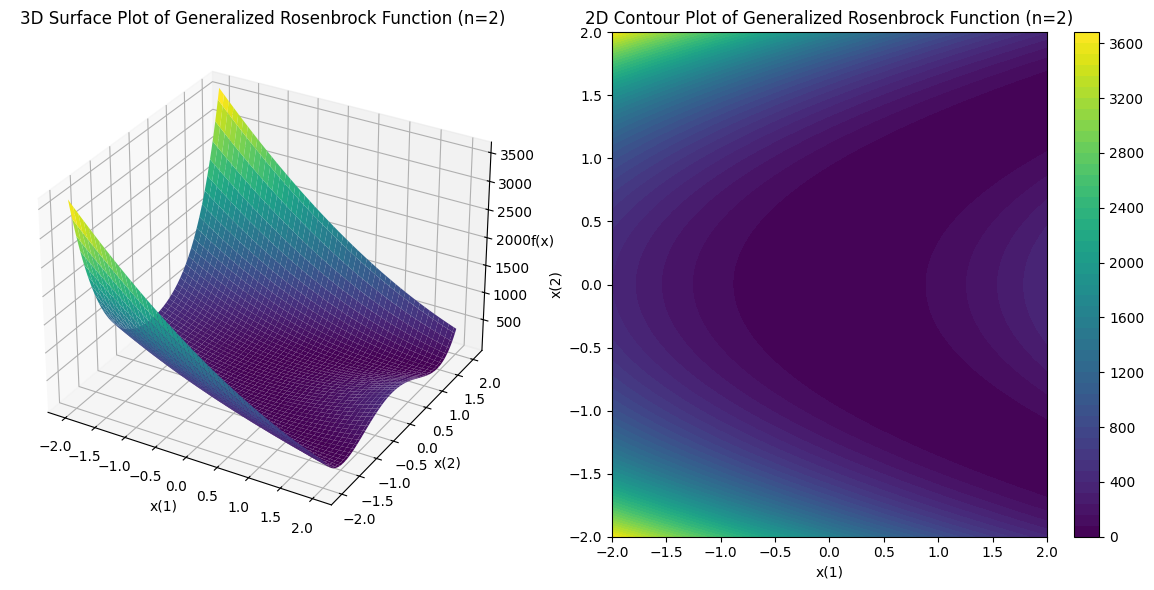

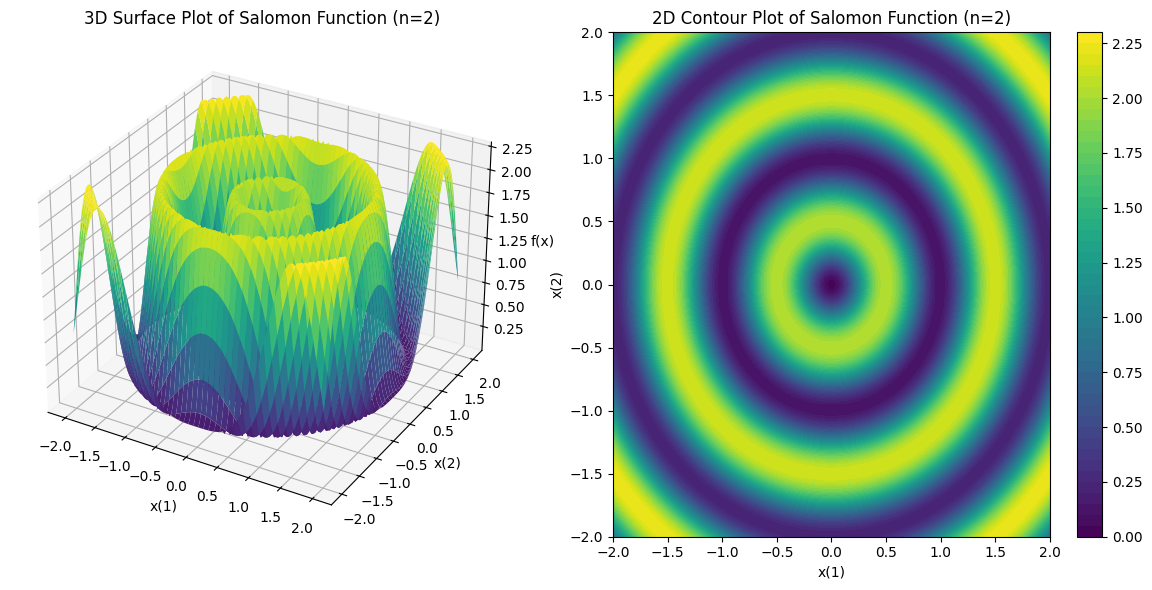

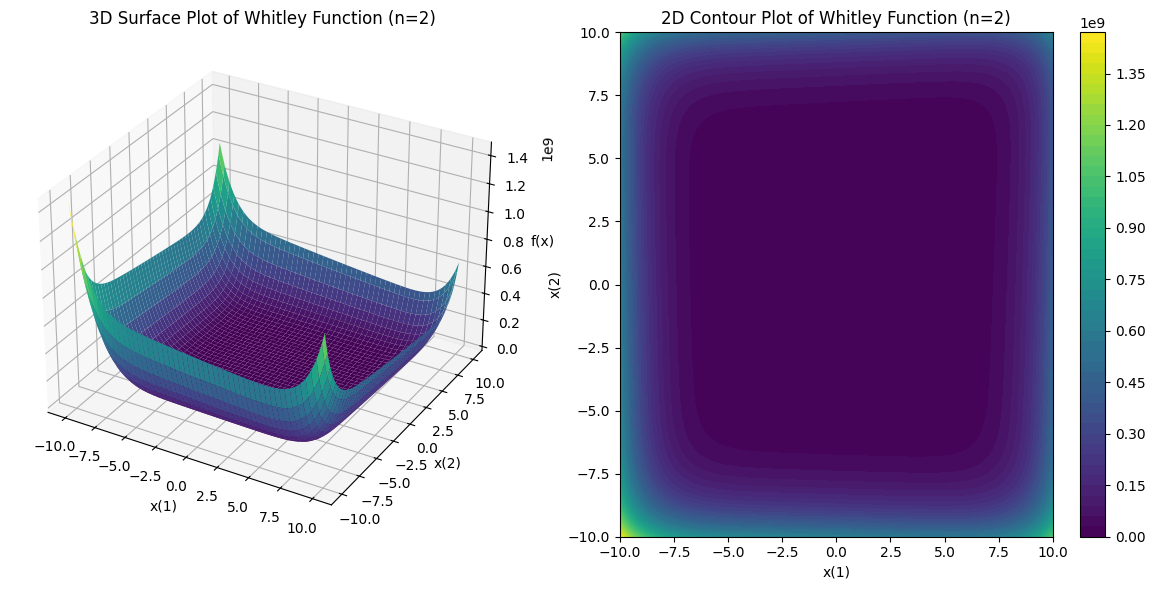

In [11]:
plot_3d_and_contour([-2,2], rosenbrock, "Generalized Rosenbrock Function (n=2)")
plot_3d_and_contour([-2,2], salomon, "Salomon Function (n=2)")
plot_3d_and_contour([-10,10], whitley, "Whitley Function (n=2)")